In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
from typing import Mapping

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import wandb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from biobank_olink.constants import PROJECT_DATA

nb_data = PROJECT_DATA / "olink"
olink_xlsx = nb_data / "Olink population_ASI_only.xlsx"

sns.set_theme()
pl.__version__

'1.14.0'

In [2]:
feat2code = {
    "SBP": "4080",
    "DBP": "4079",
}

bp_df = (
    pl.scan_csv(nb_data / "BP_ASI_pulserate_instances0123_participant.csv")
    .select(
        "eid",
        *[
            pl.concat_list(f"^{code}-0.[0-9]$").list.mean().alias(feat)
            for feat, code in feat2code.items()
        ],
    )
    .filter(pl.col("SBP").is_not_null(), pl.col("DBP").is_not_null())
).collect()

In [3]:
index_cols = ["sex", "age", "BMI", "Smokinstatus", "Alcoholintakefrequency", "HTNgroup", "eid"]
cols = ["protein_id", "result"] + index_cols

coding = pl.read_csv(nb_data / "coding143.tsv", separator="\t").with_columns(
    pl.col("meaning").str.split(";").list.get(0).alias("meaning"),
)
df = (
    pl.scan_parquet(olink_xlsx.with_suffix(".parquet"))
    .filter(pl.col("HTNgroup").is_in([0, 1]))
    .select(cols)
    .with_columns(
        pl.col("protein_id").replace_strict(
            coding["coding"], coding["meaning"], return_dtype=pl.String
        )
    )
).collect()

df = df.pivot(on="protein_id", index=index_cols, values="result")
df_all = (
    df.with_columns(
        df["Smokinstatus"].to_dummies(drop_first=True)
    )
    .drop("Smokinstatus", "HTNgroup")
    # Adds SBP and DBP
    .join(bp_df, on="eid", how="inner", coalesce=True)
    .drop("eid")
)

f"all: {df_all.shape} (including SBP and DBP)"

'all: (9536, 2932) (including SBP and DBP)'

In [4]:
def shap_to_importance(values, feat_names) -> pd.Series:
    return (
        pd.Series(np.abs(values.values).sum(axis=0), index=feat_names)
        .sort_values(ascending=False)
    )


def print_true_vs_pred(y_true, y_pred, title="Train"):
    ax = sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
    max_lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_lim = min(ax.get_xlim()[0], ax.get_ylim()[0])
    ax.set(xlabel="y_true", ylabel="y_pred", title=title,
           xlim=(min_lim, max_lim), ylim=(min_lim, max_lim))


def setup_xgb(config: Mapping, seed=42, device="gpu") -> xgb.XGBRegressor:
    xgb_params = dict(config)

    early_stop = xgb.callback.EarlyStopping(
        rounds=10, save_best=True
    )

    return xgb.XGBRegressor(
        tree_method="hist",
        device=device,
        random_state=seed,
        callbacks=[early_stop],
        **xgb_params,
    )


def eval_xgb(x, y, config, seed=42, device="gpu") -> xgb.XGBRegressor:
    x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=seed)

    clf = setup_xgb(config, seed, device)
    clf.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], verbose=10)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    y_train_pred = clf.predict(x_train)
    corr_train = np.corrcoef(y_train, y_train_pred)[1, 0]
    print_true_vs_pred(y_train, y_train_pred,
                       title=f"Train (r2={clf.score(x_train, y_train):.4f}, corr={corr_train:.4f})")

    plt.subplot(1, 2, 2)
    y_eval_pred = clf.predict(x_eval)
    corr_eval = np.corrcoef(y_eval, y_eval_pred)[1, 0]
    print_true_vs_pred(y_eval, y_eval_pred,
                       title=f"Eval (r2={clf.score(x_eval, y_eval):.4f}, corr={corr_eval:.4f})")
    return clf


def get_elbow_point(series: pd.Series) -> int:
    from kneed import KneeLocator

    x = np.arange(0, len(series))
    y = series.values
    kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow

    ax = series.plot.line()
    ax.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    return elbow_point


### SBP

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:19.53568
[10]	validation_0-rmse:18.30722
[20]	validation_0-rmse:17.58673
[30]	validation_0-rmse:17.14164
[40]	validation_0-rmse:16.87143
[50]	validation_0-rmse:16.59633
[60]	validation_0-rmse:16.37400
[70]	validation_0-rmse:16.19748
[80]	validation_0-rmse:16.05304
[90]	validation_0-rmse:15.95750
[100]	validation_0-rmse:15.86786
[110]	validation_0-rmse:15.76677
[120]	validation_0-rmse:15.71322
[130]	validation_0-rmse:15.65367
[140]	validation_0-rmse:15.61724
[150]	validation_0-rmse:15.57547
[160]	validation_0-rmse:15.55334
[170]	validation_0-rmse:15.53600
[180]	validation_0-rmse:15.51926
[190]	validation_0-rmse:15.47307
[200]	validation_0-rmse:15.45613
[210]	validation_0-rmse:15.41555
[220]	validation_0-rmse:15.39620
[230]	validation_0-rmse:15.38078
[240]	validation_0-rmse:15.34438
[250]	validation_0-rmse:15.32519
[260]	validation_0-rmse:15.32154
[270]	validation_0-rmse:15.31316
[280]	validation_0-rmse:15.30903
[290]	validation_0-rmse:15.27796
[300]	validation_0-rm

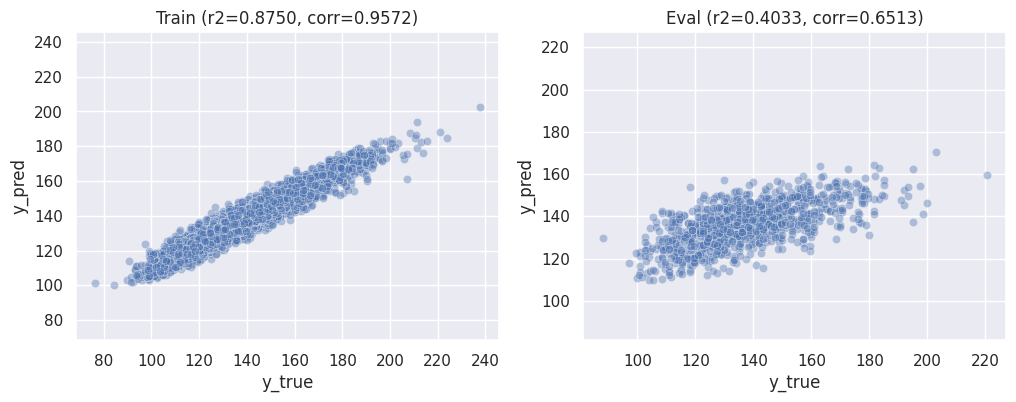

In [5]:
x_sbp, y_sbp = df_all.drop("SBP", "DBP"), df_all["SBP"]
sbp_sweep = wandb.Api().sweep("olink_sbp/sst2rxbn")
best_run = sbp_sweep.best_run(order="r2")
model_sbp = eval_xgb(x_sbp, y_sbp, best_run.config)

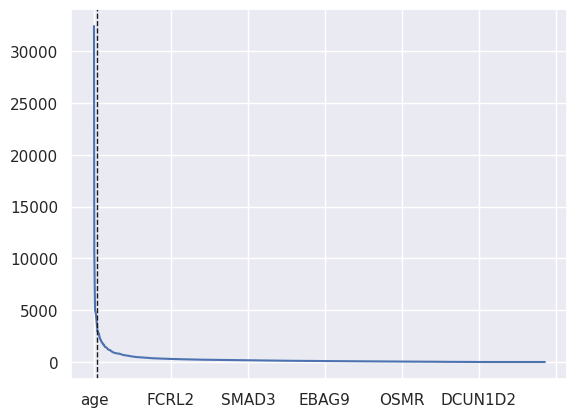

In [6]:
explainer = shap.TreeExplainer(model_sbp)
shap_values_sbp = explainer(x_sbp)
imps = shap_to_importance(shap_values_sbp, x_sbp.columns)
sbp_elbow = get_elbow_point(imps)
sbp_important_feats = imps[:sbp_elbow]

In [7]:
sbp_important_feats.index.values, f"Number of important feats: {len(sbp_important_feats)}"

(array(['age', 'REN', 'PTPRB', 'ACTA2', 'CHGB', 'NADK', 'BMI', 'SPINK6',
        'CRIP2', 'HAVCR1', 'AGER', 'ERBB2', 'PLAT', 'SLC9A3R2', 'EFNA1',
        'CLEC4A', 'LMOD1', 'AMIGO2', 'TSHB', 'CRLF1', 'CPM', 'ACAN'],
       dtype=object),
 'Number of important feats: 22')

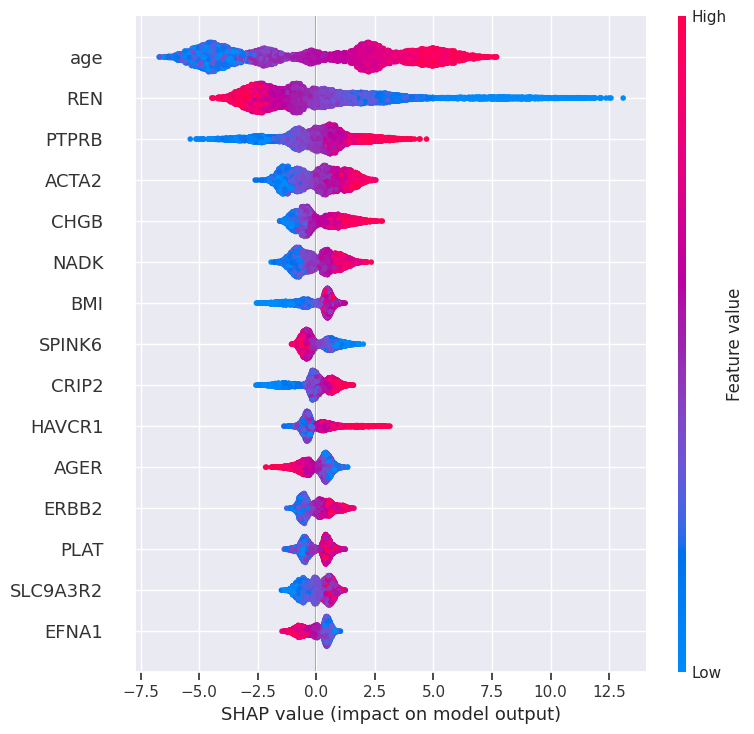

In [8]:
shap.summary_plot(shap_values_sbp, x_sbp.to_pandas(), max_display=min(len(sbp_important_feats), 15))

### DBP

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:10.19600
[10]	validation_0-rmse:9.67608
[20]	validation_0-rmse:9.38917
[30]	validation_0-rmse:9.19791
[40]	validation_0-rmse:9.06484
[50]	validation_0-rmse:8.96000
[60]	validation_0-rmse:8.86746
[70]	validation_0-rmse:8.78572
[80]	validation_0-rmse:8.71476
[90]	validation_0-rmse:8.65285
[100]	validation_0-rmse:8.61222
[110]	validation_0-rmse:8.57620
[120]	validation_0-rmse:8.52563
[130]	validation_0-rmse:8.48219
[140]	validation_0-rmse:8.44526
[150]	validation_0-rmse:8.42222
[160]	validation_0-rmse:8.42269
[170]	validation_0-rmse:8.41430
[180]	validation_0-rmse:8.41538
[190]	validation_0-rmse:8.40869
[200]	validation_0-rmse:8.37513
[210]	validation_0-rmse:8.36405
[220]	validation_0-rmse:8.34956
[230]	validation_0-rmse:8.33614
[240]	validation_0-rmse:8.33091
[250]	validation_0-rmse:8.32052
[260]	validation_0-rmse:8.30909
[270]	validation_0-rmse:8.29847
[280]	validation_0-rmse:8.28313
[290]	validation_0-rmse:8.28556
[292]	validation_0-rmse:8.28697


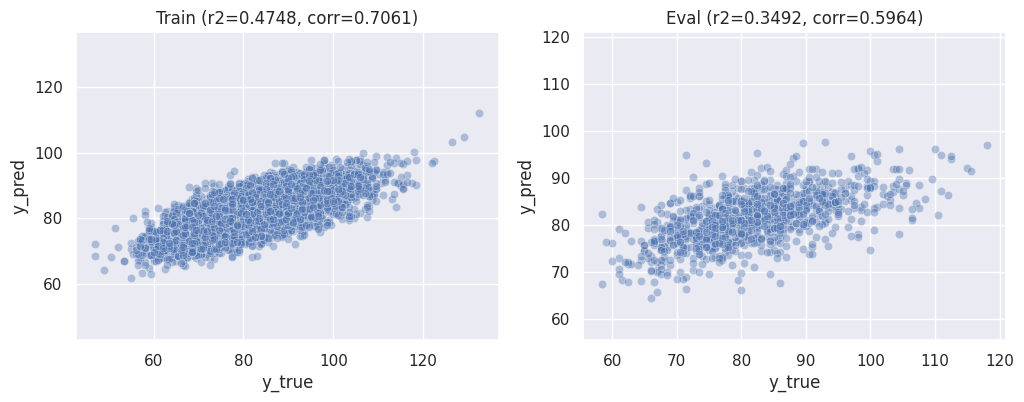

In [9]:
x_dbp, y_dbp = df_all.drop("SBP", "DBP"), df_all["DBP"]
dbp_sweep = wandb.Api().sweep("olink_dbp/xsbh58nq")
best_run = dbp_sweep.best_run(order="r2")
model_dbp = eval_xgb(x_dbp, y_dbp, best_run.config)

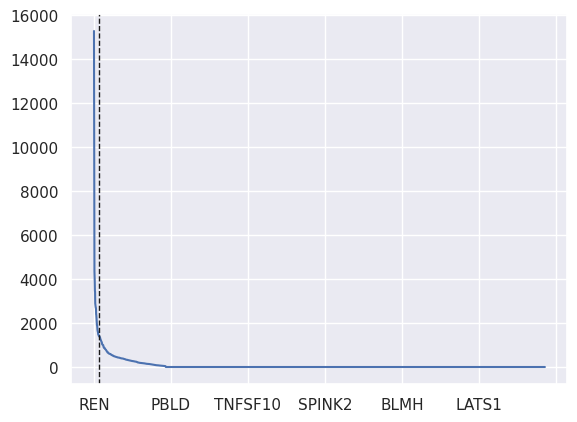

In [10]:
explainer = shap.TreeExplainer(model_dbp)
shap_values_dbp = explainer(x_dbp)
imps = shap_to_importance(shap_values_dbp, x_dbp.columns)
dbp_elbow = get_elbow_point(imps)
dbp_important_feats = imps[:dbp_elbow]

In [11]:
dbp_important_feats.index.values, f"Number of important feats: {len(dbp_important_feats)}"

(array(['REN', 'BMI', 'PTPRB', 'ACTA2', 'ERBB2', 'NTRK3', 'APCS', 'ACY1',
        'PLA2G10', 'ANGPT2', 'NADK', 'LAYN', 'CRIP2', 'IGFBP2', 'PLAT',
        'COL4A1', 'CHGB', 'CCER2', 'GCG', 'FABP1', 'NTproBNP', 'ACAN',
        'TSHB', 'RGMA', 'GGT1', 'GIP', 'LMOD1', 'AGER', 'IGSF9', 'FOLR1',
        'PYY', 'PIK3IP1'], dtype=object),
 'Number of important feats: 32')

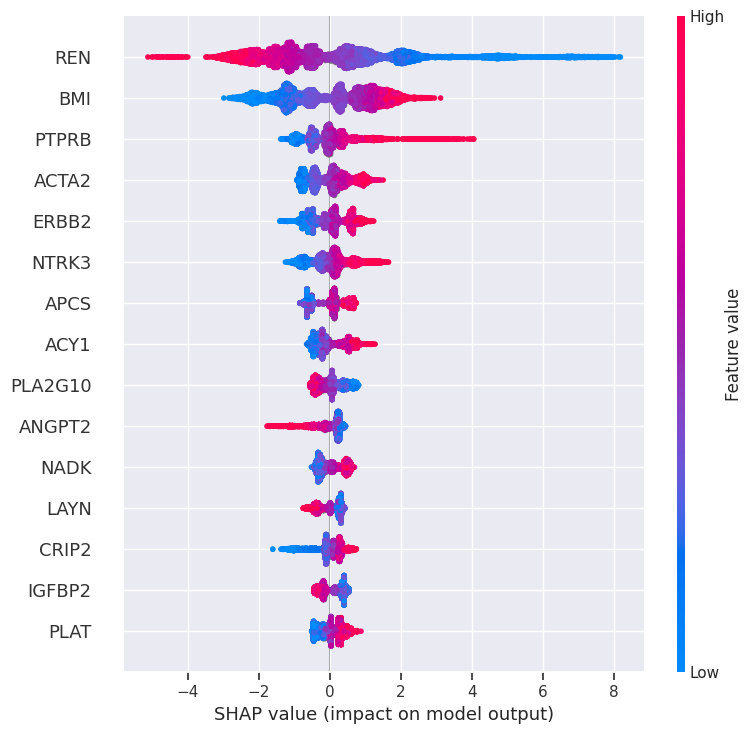

In [12]:
shap.summary_plot(shap_values_dbp, x_dbp.to_pandas(), max_display=min(len(dbp_important_feats), 15))

## Wandb sweep

In [ ]:
def wandb_eval_xgb(config, x, y, seed=42):
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=seed)

    estimator = setup_xgb(config, seed)
    estimator.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    return estimator.score(X_eval, y_eval)


target = "DBP"
project_name = f"olink_{target.lower()}"
x, y = df_all.drop("SBP", "DBP"), df_all[target]

objective = partial(wandb_eval_xgb, x=x, y=y)


def main():
    wandb.init(project=project_name)
    score = max(objective(wandb.config), -10)
    wandb.log({"r2": score})


sweep_configurations = {
    "method": "bayes",
    "metric": {"name": "r2", "goal": "maximize"},
    "parameters": {
        'n_estimators': {'distribution': 'int_uniform', 'min': 50, 'max': 500},
        'max_depth': {'distribution': 'int_uniform', 'min': 1, 'max': 10},
        'learning_rate': {'distribution': 'log_uniform_values', 'min': 0.001, 'max': 0.1},
        'subsample': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'gamma': {'distribution': 'uniform', 'min': 0, 'max': 10},
        'min_child_weight': {'distribution': 'int_uniform', 'min': 1, 'max': 20},
        'reg_alpha': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
        'reg_lambda': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
    },
}

sweep_id = wandb.sweep(sweep_configurations, project=project_name)
sweep_id

In [ ]:
wandb.teardown()
wandb.agent(sweep_id, function=main, count=200)